# Tourism-Large data DeepAR

<a href="https://colab.research.google.com/github/Nixtla/hierarchicalforecast/blob/main/nbs/examples/AustralianDomesticTourism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In many cases, only the time series at the lowest level of the hierarchies (bottom time series) are available. `HierarchicalForecast` has tools to create time series for all hierarchies. In this notebook we will see how to do it.

In [1]:

# compute base forecast no coherent
from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, Naive
import pandas as pd

#obtain hierarchical reconciliation methods and evaluation
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut
from datasetsforecast.hierarchical import HierarchicalData
import numpy as np
from statsforecast.models import ETS


/home/arindam/anaconda3/envs/kdd23/lib/python3.9/site-packages/statsforecast/core.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Aggregate bottom time series

In this example we will use the [Tourism](https://otexts.com/fpp3/tourism.html) dataset from the [Forecasting: Principles and Practice](https://otexts.com/fpp3/) book. The dataset only contains the time series at the lowest level, so we need to create the time series for all hierarchies.

In [2]:
# Load TourismSmall dataset
Y_df, S, tags = HierarchicalData.load('./data', 'TourismLarge')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

In [3]:
Y_df

,unique_id,ds,y
0,TotalAll,1998-01-01,45151.071280
1,TotalAll,1998-02-01,17294.699551
2,TotalAll,1998-03-01,20725.114184
3,TotalAll,1998-04-01,25388.612353
4,TotalAll,1998-05-01,20330.035211
...,...,...,...
126535,GBDOth,2016-08-01,0.000000
126536,GBDOth,2016-09-01,0.000000
126537,GBDOth,2016-10-01,0.000000
126538,GBDOth,2016-11-01,0.000000


In [4]:
unq_ids = Y_df["unique_id"].unique()
num_series = len(unq_ids)
num_series

555

In [5]:
len_series = len(Y_df[Y_df["unique_id"] == unq_ids[0]])
len_series

228

In [6]:
S

,AAAHol,AAAVis,AAABus,AAAOth,AABHol,AABVis,AABBus,AABOth,ABAHol,ABAVis,...,GBBBus,GBBOth,GBCHol,GBCVis,GBCBus,GBCOth,GBDHol,GBDVis,GBDBus,GBDOth
TotalAll,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
AAll,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BAll,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAll,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DAll,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GBCOth,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
GBDHol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
GBDVis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
GBDBus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [7]:
tags

{'Country': array(['TotalAll'], dtype=object),
 'Country/State': array(['AAll', 'BAll', 'CAll', 'DAll', 'EAll', 'FAll', 'GAll'],
       dtype=object),
 'Country/State/Zone': array(['AAAll', 'ABAll', 'ACAll', 'ADAll', 'AEAll', 'AFAll', 'BAAll',
        'BBAll', 'BCAll', 'BDAll', 'BEAll', 'CAAll', 'CBAll', 'CCAll',
        'CDAll', 'DAAll', 'DBAll', 'DCAll', 'DDAll', 'EAAll', 'EBAll',
        'ECAll', 'FAAll', 'FBAll', 'FCAll', 'GAAll', 'GBAll'], dtype=object),
 'Country/State/Zone/Region': array(['AAAAll', 'AABAll', 'ABAAll', 'ABBAll', 'ACAAll', 'ADAAll',
        'ADBAll', 'ADCAll', 'ADDAll', 'AEAAll', 'AEBAll', 'AECAll',
        'AEDAll', 'AFAAll', 'BAAAll', 'BABAll', 'BACAll', 'BBAAll',
        'BCAAll', 'BCBAll', 'BCCAll', 'BDAAll', 'BDBAll', 'BDCAll',
        'BDDAll', 'BDEAll', 'BDFAll', 'BEAAll', 'BEBAll', 'BECAll',
        'BEDAll', 'BEEAll', 'BEFAll', 'BEGAll', 'BEHAll', 'CAAAll',
        'CABAll', 'CACAll', 'CBAAll', 'CBBAll', 'CBCAll', 'CBDAll',
        'CCAAll', 'CCBAll', 'CC

In [8]:
len(tags.keys())

8

### Split Train/Test sets

We use the final horizon as test set.

In [9]:
HORIZON = 12
FREQUENCY = "1M"

In [10]:
Y_test_df = Y_df.groupby('unique_id').tail(HORIZON)
Y_train_df = Y_df.drop(Y_test_df.index)

In [11]:
Y_test_df = Y_test_df.set_index('unique_id')
Y_train_df = Y_train_df.set_index('unique_id')

In [12]:
Y_train_df.groupby('unique_id').size()

unique_id
AAAAll      216
AAABus      216
AAAHol      216
AAAOth      216
AAAVis      216
           ... 
TotalAll    216
TotalBus    216
TotalHol    216
TotalOth    216
TotalVis    216
Length: 555, dtype: int64

## Computing base forecasts

The following cell computes the **base forecasts** for each time series in `Y_df` using the `auto_arima` and `naive` models. Observe that `Y_hat_df` contains the forecasts but they are not coherent.

In [13]:
# Convert train df to gluonts format
# from data_utils import convert_df_to_gluonts_iter

from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

def convert_df_to_gluonts_iter(df: pd.DataFrame, horizon: int, frequency: str):

    unq_ids = np.unique(df.index)

    all_ts = []
    for id_ in unq_ids:
        df_one_ts = df[df.index == id_].sort_values("ds")
        start_time = df_one_ts["ds"][0]
        target_vals = df_one_ts["y"].values
        # print(id_, start_time, target_vals)
        all_ts.append(
            {
                FieldName.TARGET: target_vals,
                FieldName.START: start_time,
                FieldName.ITEM_ID: id_
            }
        )
    return ListDataset(all_ts, freq=frequency)

gluon_dset_train = convert_df_to_gluonts_iter(Y_train_df, HORIZON, FREQUENCY)
gluon_dset_test = convert_df_to_gluonts_iter(Y_df.set_index('unique_id'), HORIZON, FREQUENCY)

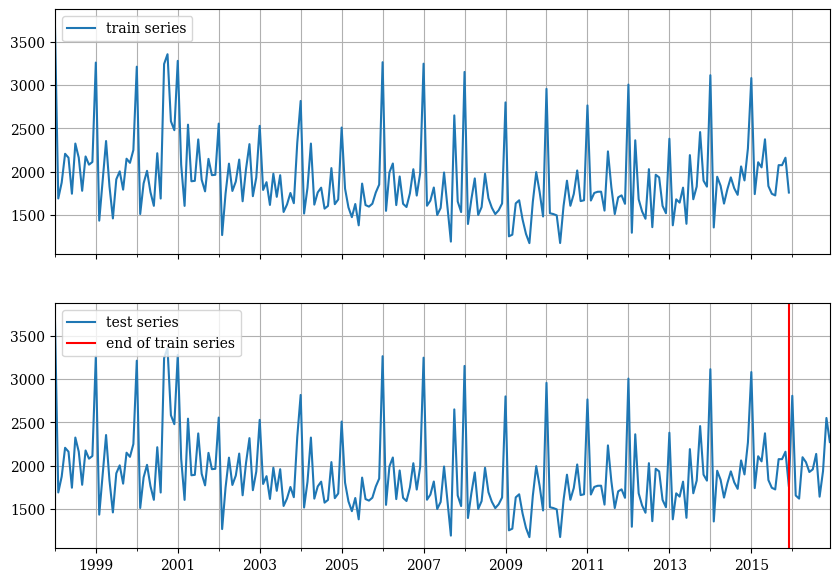

In [14]:
import matplotlib.pyplot as plt
from gluonts.dataset.util import to_pandas

train_entry = next(iter(gluon_dset_train))
test_entry = next(iter(gluon_dset_test))

test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color="r")  # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()



In [15]:

from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas
from gluonts.model.n_beats import NBEATSEnsembleEstimator
from gluonts.mx.trainer import Trainer

EPOCHS = 10
FREQ = "1Q"
LR = 1e-3
BATCHES_PER_EPOCH = 100

# Get best model params from HPO
CONTEXT_LEN = 2*HORIZON
# num_layers = 2
# dropout_rate = 0.4
# EPOCHS = 25
# num_cells = 40

estimator = NBEATSEnsembleEstimator(
    freq=FREQ,
    prediction_length=HORIZON,
    trainer=Trainer(ctx="cpu", epochs=EPOCHS, learning_rate=1e-3, num_batches_per_epoch=BATCHES_PER_EPOCH),
    meta_context_length=[HORIZON, CONTEXT_LEN],
    meta_loss_function=["sMAPE"],
    meta_bagging_size=5,
)

predictor = estimator.train(gluon_dset_train)

# # Fit and predict with N-BEATS and N-HiTS models
# models = [NBEATS(input_size=CONTEXT_LEN, h=HORIZON, max_epochs=EPOCHS)]
# fcst = NeuralForecast(models=models, freq='M')
# fcst.fit(df=Y_train_df)

INFO:gluonts.mx.context:Using CPU
/home/arindam/anaconda3/envs/kdd23/lib/python3.9/site-packages/gluonts/model/n_beats/__init__.py:22: FutureWarning: The module gluonts.model.n_beats has been moved to gluonts.mx.model.n_beats. In GluonTS v0.12 it will be no longer possible to use the old path. Try to use 'from gluonts.mx import NBEATSEstimator, NBEATSEnsembleEstimator, NBEATSEnsemblePredictor'.
  warnings.warn(
INFO:root:Training estimator 1/10.
INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001


TRAINER:gluonts.mx.trainer._base.Trainer(add_default_callbacks=True, callbacks=None, clip_gradient=10.0, ctx=mxnet.context.Context("cpu", 0), epochs=10, hybridize=True, init="xavier", learning_rate=0.001, num_batches_per_epoch=100, weight_decay=1e-08)


100%|██████████| 100/100 [00:27<00:00,  3.62it/s, epoch=1/10, avg_epoch_loss=8.34]
INFO:gluonts.trainer:Epoch[0] Elapsed time 27.666 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=8.336324
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:26<00:00,  3.75it/s, epoch=2/10, avg_epoch_loss=8.27]
INFO:gluonts.trainer:Epoch[1] Elapsed time 26.650 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=8.273377
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:25<00:00,  3.98it/s, epoch=3/10, avg_epoch_loss=9.87]
INFO:gluonts.trainer:Epoch[2] Elapsed time 25.158 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=9.868467
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:27<00:00,  3.61it/s, epoch=4/10, avg_epoch_loss=9.89]
INFO:gluonts.trainer:Epoch[3] Elapsed time 27.757 seconds
INFO:gluonts.trainer:Epoch[3] Evaluation metric 'epoch_loss'=9.8910

In [ ]:
from gluonts.evaluation import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=gluon_dset_test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color="g")
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

forecasts = list(forecast_it)
tss = list(ts_it)
ts_entry = tss[0]
forecast_entry = forecasts[0]
plot_prob_forecasts(ts_entry, forecast_entry)

### Convert the forecasts iterator into pandas df

In [ ]:
def convert_gluonts_iter_to_df(
    gluon_iter,
    test_dates
):
    out = []
    dates = []
    ids = []
    for x in gluon_iter:
        ids.extend([x.item_id]*HORIZON)
        # out.extend(np.mean(x.samples, axis=0).reshape(-1))
        out.extend(x.samples.flatten())
        dates.extend(test_dates)
    out = pd.DataFrame({"unique_id": ids, "ds": dates, "y_hat": out})
    out = out.set_index("unique_id")
    return out

test_dates = Y_test_df["ds"].unique()
test_dates.sort()
forecast_df = convert_gluonts_iter_to_df(forecasts, test_dates)
print(forecast_df)

### Computing in-sample forecasts needed for MinT, ERM methods
Note that the model is already trained on the training part of the data. Now, the in-sample forecasts are obtained by a moving window method. These in-sample forecasts are needed to estimate the residual covariance matrix in MinT and ERM methods.

In [ ]:
dates = Y_df.ds.unique()
dates.sort()
dates_train = Y_train_df.ds.unique()
dates_train.sort()
Y_hat_in_sample = None
for i in range(0, len(dates_train)-HORIZON-CONTEXT_LEN+1):
    # print(i, i+CONTEXT_LEN, i+CONTEXT_LEN+HORIZON)
    backtest_history = Y_train_df[(Y_train_df.ds >= dates[i]) & (Y_train_df.ds < dates[i+CONTEXT_LEN])]
    end_pt = i+CONTEXT_LEN+HORIZON
    if end_pt < len(dates_train):
        backtest_test_true = Y_train_df[(Y_train_df.ds >= dates[i+CONTEXT_LEN]) & (Y_train_df.ds < dates[end_pt])]
    else:
        backtest_test_true = Y_train_df[(Y_train_df.ds >= dates[i+CONTEXT_LEN])]
    # print(len(backtest_test_true))
    backtest_history_iter = convert_df_to_gluonts_iter(backtest_history, HORIZON, FREQUENCY)
    forecast_it, ts_it = make_evaluation_predictions(
                            dataset=backtest_history_iter,  # test dataset
                            predictor=predictor,  # predictor
                            num_samples=100,  # number of sample paths we want for evaluation
                        )
    forecasts = list(forecast_it)
    # Y_hat_in_sample_part = fcst.predict(df=backtest_history)
    test_dates = backtest_test_true["ds"].unique()
    test_dates.sort()
    Y_hat_in_sample_part = convert_gluonts_iter_to_df(forecasts, test_dates)
    # Y_hat_in_sample_part["ds"] = backtest_test_true["ds"].values
    first_horizon_date = backtest_test_true["ds"].unique()[0]
    if Y_hat_in_sample is None:
        Y_hat_in_sample = Y_hat_in_sample_part[Y_hat_in_sample_part["ds"] == first_horizon_date]
    else:
        if i == len(dates_train)-HORIZON-CONTEXT_LEN:
            Y_hat_in_sample = pd.concat([Y_hat_in_sample, Y_hat_in_sample_part])
        else:
            Y_hat_in_sample = pd.concat([Y_hat_in_sample, Y_hat_in_sample_part[Y_hat_in_sample_part["ds"] == first_horizon_date]])

In [ ]:
Y_hat_in_sample

## Predict on test

In [ ]:
Y_hat_df = forecast_df
Y_hat_df

In [ ]:
# Create Y_df with y_hat_in_sample
Y_train_df_extended = Y_train_df.merge(Y_hat_in_sample, on=["ds", "unique_id"], how="inner")
Y_train_df_extended

## Reconcile forecasts

The following cell makes the previous forecasts coherent using the `HierarchicalReconciliation` class. Since the hierarchy structure is not strict, we can't use methods such as `TopDown` or `MiddleOut`. In this example we use `BottomUp` and `MinTrace`.

In [ ]:
from hierarchicalforecast.methods import BottomUp, MinTrace, ERM

reconcilers = [
    BottomUp(),
    MinTrace(method='mint_shrink'),
    MinTrace(method='ols'),
    ERM(method='reg')
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)
Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_train_df_extended, S=S, tags=tags)

The dataframe `Y_rec_df` contains the reconciled forecasts.

In [ ]:
Y_rec_df

## Evaluation 

The `HierarchicalForecast` package includes the `HierarchicalEvaluation` class to evaluate the different hierarchies and also is capable of compute scaled metrics compared to a benchmark model.

In [ ]:
tags.keys()

In [ ]:
from hierarchicalforecast.evaluation import HierarchicalEvaluation

def rmse(y, y_hat):
    return np.mean(np.sqrt(np.mean((y-y_hat)**2, axis=1)))

def mase(y, y_hat, y_insample, seasonality=4):
    errors = np.mean(np.abs(y - y_hat), axis=1)
    scale = np.mean(np.abs(y_insample[:, seasonality:] - y_insample[:, :-seasonality]), axis=1)
    return np.mean(errors / scale)

def rmsse(y, y_hat, y_insample):
    errors = np.mean(np.square(y - y_hat), axis=1)
    scale = np.mean(np.square(y_insample[:, 1:] - y_insample[:, :-1]), axis=1)
    return np.mean(np.sqrt(errors / scale))

eval_tags = {}
for k in tags.keys():
    eval_tags[k] = tags[k]

evaluator = HierarchicalEvaluation(evaluators=[rmse, mase, rmsse])
evaluation = evaluator.evaluate(
        Y_hat_df=Y_rec_df, Y_test_df=Y_test_df,
        tags=eval_tags, Y_df=Y_train_df
)
evaluation = evaluation.drop('Overall')
# evaluation.columns = ['Base', 'BottomUp', 'MinTrace(mint_shrink)', 'MinTrace(ols)']
evaluation.columns = ['Base', 'BottomUp', 'MinTrace(ols)', 'MinTrace(mint_shrink)', 'ERM']
evaluation = evaluation.applymap('{:.4f}'.format)

### RMSE

The following table shows the performance measured using RMSE across levels for each reconciliation method.

In [ ]:
score_df = evaluation.query('metric == "rmse"')
score_df

### MASE


The following table shows the performance measured using MASE across levels for each reconciliation method.

In [ ]:
evaluation.query('metric == "mase"')

### RMSSE

In [ ]:
score_df = evaluation.query('metric == "rmsse"')
score_df

In [ ]:
score_df.astype(float).mean()

### Comparison fable

Observe that we can recover the results reported by the [Forecasting: Principles and Practice](https://otexts.com/fpp3/tourism.html). The original results were calculated using the R package [fable](https://github.com/tidyverts/fable).

![Fable's reconciliation results](./imgs/AustralianDomesticTourism-results-fable.png)

### References
- [Hyndman, R.J., & Athanasopoulos, G. (2021). "Forecasting: principles and practice, 3rd edition: 
Chapter 11: Forecasting hierarchical and grouped series.". OTexts: Melbourne, Australia. OTexts.com/fpp3 
Accessed on July 2022.](https://otexts.com/fpp3/hierarchical.html)
- [Rob Hyndman, Alan Lee, Earo Wang, Shanika Wickramasuriya, and Maintainer Earo Wang (2021). "hts: Hierarchical and Grouped Time Series". URL https://CRAN.R-project.org/package=hts. R package version 0.3.1.](https://cran.r-project.org/web/packages/hts/index.html)
- [Mitchell O’Hara-Wild, Rob Hyndman, Earo Wang, Gabriel Caceres, Tim-Gunnar Hensel, and Timothy Hyndman (2021). "fable: Forecasting Models for Tidy Time Series". URL https://CRAN.R-project.org/package=fable. R package version 6.0.2.](https://CRAN.R-project.org/package=fable)